# Driver Drowsiness Detection

- [x] Data reading and splitting
- [x] Data Normalization and Augmentation
- [x] Custom built CNN
- [ ] Transfer Learning on CNN
- [ ] Plotting the outcomes
- [ ] Extract face and eyes OpenCv

In [1]:
# Start writing code here...
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


Constants for the CNN model

In [13]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "data"

# Number of classes in the dataset
num_classes = 4

# image size after resizing
img_size = (224, 224)

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = True

# mean and standard deviation of RGB channels of images
mean = np.array([0.4722, 0.4101, 0.3794])
std = np.array([0.2401, 0.2342, 0.2323])

Data is stored in the form of images which can be loaded into PyTorch `Dataset` using `torchvision.datasets.ImageFolder`. It assigns labels to each image using the directory in which that image is stored. So an image in `archive/train/Closed` will be given a label `0`.

## Data Processing

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
torch.manual_seed(17)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(image_datasets)

Initializing Datasets and Dataloaders...
{'train': Dataset ImageFolder
    Number of datapoints: 2024
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4722 0.4101 0.3794], std=[0.2401 0.2342 0.2323])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 430
    Root location: data/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.4722 0.4101 0.3794], std=[0.2401 0.2342 0.2323])
           )}


In [4]:
# transformations = transforms.Compose([
#     transforms.Resize(img_size),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)
# ])

# # train_data is list<tuples<image, label>>
# train_data = ImageFolder(data_dir + "/train/", transform=transformations)
# test_data = ImageFolder(data_dir + "/test/", transform=transformations)
# val_data = ImageFolder(data_dir + "/val/", transform=transformations)

# # Convert the dataset to batches
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# print(f"train: {train_data}")
# print(f"test: {test_data}")
# print(f"val: {val_data}")

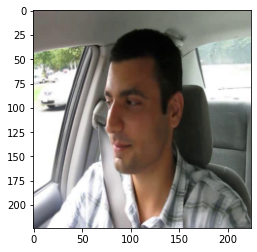

In [5]:
def imshow(img):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0)) 
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    
sample_image = image_datasets['train'][1240][0]
imshow(sample_image)
# plt.imshow(tensor_image.permute(1, 2, 0))

In [26]:
labels_map = image_datasets['train'].class_to_idx.copy()
classes = image_datasets['train'].classes
print(labels_map)

{'Closed': 0, 'Open': 1, 'no_yawn': 2, 'yawn': 3}


### ResNet50 Transfer Learning

In [35]:
def initialize_model(use_pretrained=True):
    model = torchvision.models.resnet50(pretrained=use_pretrained)
    for param in model.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.Linear(256, 4)
    )

    return model


In [36]:
# initialize resnet50 model
model_conv = initialize_model(use_pretrained=True)
model_conv = model_conv.to(device)

# define loss function
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized in fixed feture extraction
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# for epoch in range(1):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 100 == 99:    # print every 100 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
#             running_loss = 0.0

# print('Finished Training')

## Training the Model

In [17]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    acc_history_dict = {'train': [], 'val' :[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # train and validation accuracy
            acc_history_dict[phase].append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history_dict

In [21]:
model_conv, acc_history_dict = train_model(model_conv, dataloaders_dict, criterion, optimizer_conv,
                                exp_lr_scheduler, num_epochs)

Epoch 0/4
----------
train Loss: 0.1986 Acc: 0.9259
val Loss: 0.1920 Acc: 0.9209

Epoch 1/4
----------
train Loss: 0.1816 Acc: 0.9313
val Loss: 0.1795 Acc: 0.9233

Epoch 2/4
----------
train Loss: 0.1595 Acc: 0.9476
val Loss: 0.1782 Acc: 0.9209

Epoch 3/4
----------
train Loss: 0.1675 Acc: 0.9348
val Loss: 0.1733 Acc: 0.9256

Epoch 4/4
----------
train Loss: 0.1517 Acc: 0.9447
val Loss: 0.1737 Acc: 0.9209

Training complete in 1m 42s
Best val Acc: 0.925581


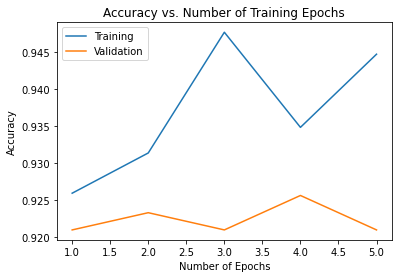

In [22]:
# Plot the training curves of training and validation accuracy vs
#  number of training epochs for the transfer learning method on resnet50
train_hist = []
train_hist = [h.cpu().numpy() for h in acc_history_dict['train']]
val_hist = []
val_hist = [h.cpu().numpy() for h in acc_history_dict['val']]

plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),train_hist,label="Training")
plt.plot(range(1,num_epochs+1),val_hist, label="Validation")
plt.legend()
# plt.savefig('accuracy_epoch.pdf')
plt.show()

## Test Accuracy

In [38]:
transformations = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data = ImageFolder(data_dir + "/test/", transform=transformations)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = model_conv(inputs)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 24 %


In [39]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_conv(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Closed is 18.0 %
Accuracy for class: Open  is 22.7 %
Accuracy for class: no_yawn is 20.0 %
Accuracy for class: yawn  is 25.7 %


### Saving and Loading the model for testing

In [28]:
PATH = './transfer_model.pth'
torch.save(model_conv.state_dict(), PATH)

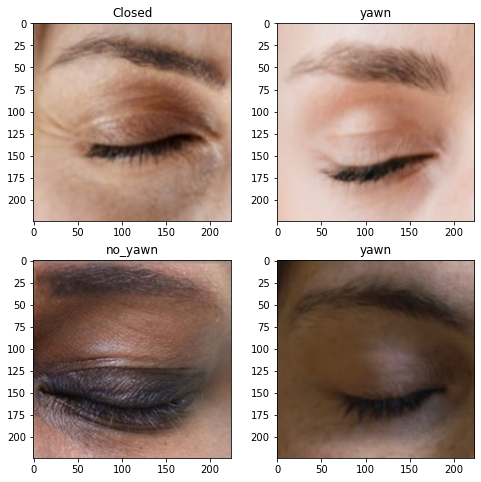

In [37]:
net = initialize_model(use_pretrained=False)

sample_data = next(iter(test_loader))
imgs = sample_data[0][:4]

# make predictions
outputs = net(sample_data[0])
_, predicted = torch.max(outputs, 1)

_, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

# display images in a grid with the predicted labels
i = 0
for img, ax in zip(imgs, axs):
    img = img.numpy().transpose((1, 2, 0)) 
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(classes[predicted[i]])
    ax.imshow(img)
    i += 1
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ed32e5f4-af7f-4ace-9d63-2f426fc82d00' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>